# Imports

In [35]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Developing Model

## Design Sequential Model

In [2]:
# initiate model
model_seq = Sequential()

In [3]:
# add embedding layer
emb_dim = 16
vocab_size = 10000
sequence_length = 200

model_seq.add(
        Embedding(
            input_dim=vocab_size, 
            output_dim=emb_dim, 
            input_shape=(sequence_length,)
        )
    )

/home/studio-lab-user/.conda/envs/pyenv-imdb/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [4]:
# add bidirectional LSTM layer
lstm_out = 32
model_seq.add(Bidirectional(LSTM(units=lstm_out)))

In [5]:
# add intermediate dense layer
model_seq.add(Dense(units=10, activation='relu'))

In [6]:
# add final dense layer with sigmoid activation function
model_seq.add(Dense(units=1, activation='sigmoid'))

In [7]:
# compile the model
model_seq.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [8]:
# print model summary
print(model_seq.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 16)        │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 64)             │        12,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 173,205 (676.58 KB)

 Trainable params: 173,205 (676.58 KB)

 Non-trainable params: 0 (0.00 B)

None


## Creating Model Checkpoints

In [10]:
checkpoint_path = os.path.join(os.getcwd(), "training/cp.ckpt/imdb_sentiment_best_model.weights.h5")
checkpoint_dir = os.path.dirname(checkpoint_path)
print(checkpoint_dir)

/home/studio-lab-user/sagemaker-studiolab-notebooks/imdb-review-classification/training/cp.ckpt


In [11]:
# checkpoint_filepath = os.path.join(os.getcwd(), 'model.keras')

# Create a callback that saves the model's weights
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path, 
    save_weights_only=True, 
    monitor='val_loss', 
    mode='min', 
    save_best_only=True
)

callbacks = [EarlyStopping(patience=2), model_checkpoint_callback]

In [12]:
# load training data
path_preprocessed = os.path.join(os.getcwd(), 'data-preprocessed')

with open(os.path.join(path_preprocessed, 'train_padded.pickle'), 'rb') as f:
    train_padded = pickle.load(f)
    
with open(os.path.join(path_preprocessed, 'y_train.pickle'), 'rb') as f:
    y_train = pickle.load(f)
    
with open(os.path.join(path_preprocessed, 'test_padded.pickle'), 'rb') as f:
    test_padded = pickle.load(f)
    
with open(os.path.join(path_preprocessed, 'y_test.pickle'), 'rb') as f:
    y_test = pickle.load(f)

In [14]:
history = model_seq.fit(
    train_padded, 
    y_train, 
    epochs=1, 
    validation_data=(test_padded, y_test),
    callbacks=[model_checkpoint_callback]
)

1172/1172 ━━━━━━━━━━━━━━━━━━━━ 133s 114ms/step - accuracy: 0.8572 - loss: 0.3454 - val_accuracy: 0.8678 - val_loss: 0.3199


## Get Metrics and Performance Graphs

In [15]:
metrics_df = pd.DataFrame(history.history)
print(metrics_df)

   accuracy      loss  val_accuracy  val_loss
0  0.866613  0.325872       0.86776  0.319884


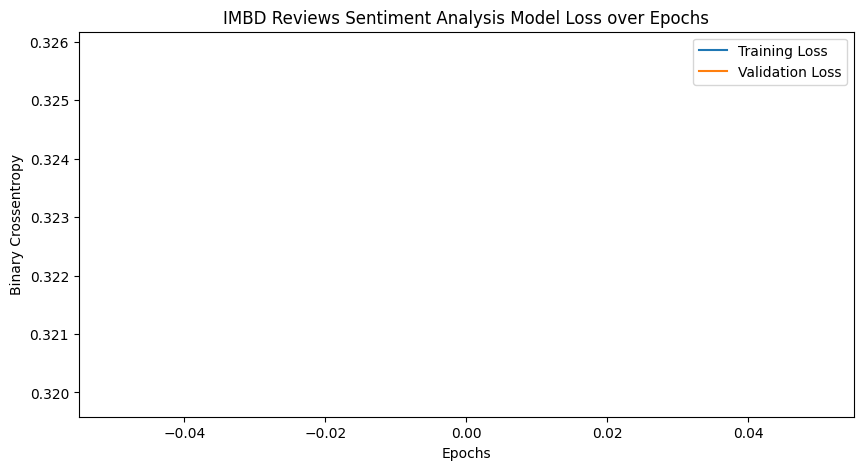

In [16]:
plt.figure(figsize=(10,5))
plt.plot(metrics_df.index, metrics_df.loss)
plt.plot(metrics_df.index, metrics_df.val_loss)
plt.title('IMBD Reviews Sentiment Analysis Model Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Binary Crossentropy')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

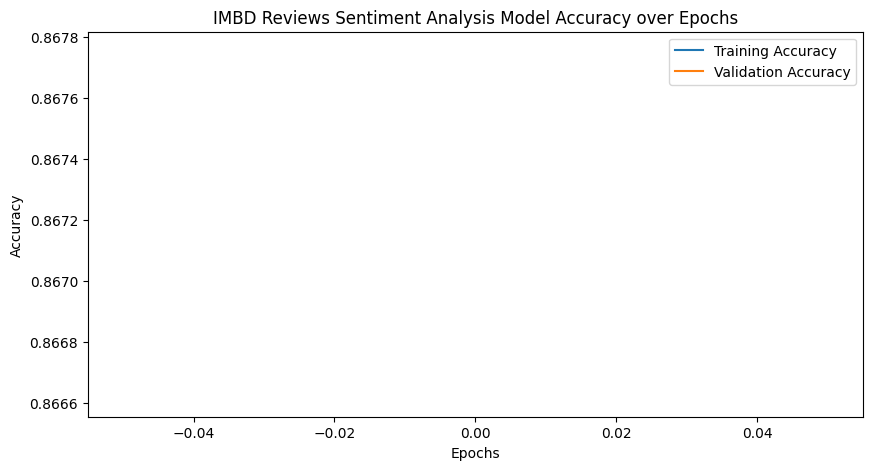

In [17]:
plt.figure(figsize=(10,5))
plt.plot(metrics_df.index, metrics_df.accuracy)
plt.plot(metrics_df.index, metrics_df.val_accuracy)
plt.title('IMBD Reviews Sentiment Analysis Model Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.show()

# Sentiment Prediction Using the Trained Model

## Load Tokenizer

In [23]:
with open(os.path.join(path_preprocessed, 'tokenizer.pickle'), 'rb') as f:
    tokenizer = pickle.load(f)

In [30]:
# tokenizer.word_index

In [36]:
# predict on a sample text without padding.
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')

print([sample_text])

['The movie was cool. The animation and the graphics were out of this world. I would recommend this movie.']


In [51]:
# tokenize reviews
sequence_length = 200
sample_sequences = tokenizer.texts_to_sequences([sample_text])
sample_sequences_padded = np.array(
            pad_sequences(
                sample_sequences, 
                maxlen=sequence_length, 
                padding='post', 
                truncating='post'
            )
        )

x_test = sample_sequences_padded.reshape(1, sequence_length)

## Load Model

In [49]:
predictions = model_seq.predict(x_test)
print(predictions.item())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
0.48500537872314453


# References

- https://www.embedded-robotics.com/sentiment-analysis-using-lstm/
- https://www.tensorflow.org/tutorials/keras/save_and_load